In [ ]:
import numba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

# Infering Ising Parameters using exact and MH sampling

In [ ]:
def generate_weights_random(N, j, h, sigma, seed):
    '''Generates a symmetric random weights array drawn from a normal distribution for a given seed'''
    rng = np.random.default_rng(seed)                    #  set random seed for reproduciblity
    W_assym = rng.normal(j/N, sigma/(N**(1/2)),(N, N))   #  get normal distributed weight matrix
    J = (W_assym+ W_assym.T)/2                           #  symmetrize the random matrix
    np.fill_diagonal(J, 0)                               #  set diagonal entries to 0 to avoid self-interactions
    H = rng.normal(h/N, sigma/(N**(1/2)),(N))            #  get normal distributed H
    return J , H

def all_possible_configs(N):
    '''Generates all possible configurations of a binary spin system of size N'''
    configs = np.zeros((2**N,N))
    for i in range(2**N):
        config = np.array([1 if x == '1' else -1 for x in np.binary_repr(i, width=N)])
        configs[i] = config
    return configs

@numba.njit
def initial_config(N: int) -> np.ndarray:
    '''Generates a 1D array of length N with random binary spin values'''
    return (np.random.randint(0, 2, size=N) * 2 - 1).astype(np.float64)

@numba.njit
def calcEnergy(config: np.ndarray, J: np.ndarray, H: np.ndarray) -> float:
    '''Calculates the energy of a given configuration'''
    config_contiguous = np.ascontiguousarray(config)        # use contiguos array for numba
    energy = -0.5 * np.dot(config_contiguous.T, np.dot(J, config_contiguous)) - np.dot(H, config_contiguous)  # *0.5 because we count each J interaction double using dot product on symmetric matrixx
    return energy

@numba.njit
def calcMag(config: np.ndarray) -> float:
    ''' Magnetizations of a given configuration '''
    return np.sum(config)

@numba.njit
def calcCorr(config: np.ndarray) -> np.ndarray:
    '''Calculates the spin-spin correlations of a given configuration. Returns a NxN matrix with the correlations'''
    return np.outer(config, config.T)

@numba.njit
def MH_move(config: np.ndarray, J: np.ndarray, H: np.ndarray, beta: float) -> np.ndarray:
    '''Implements a Monte Carlo sweep using the Metropolis-Hastings algorithm'''
    N = len(config)
    for _ in range(N):  # this loop ensures we perform a sweep
        a = np.random.randint(N)  # choose a random spin i to  flip

        #QUESTION: no factor 0.5 needed here, because we only coint each interaction once, right?
        # calculate energy change if spin i is flipped
        lf = config[a] * (np.dot(J[a], config) + H[a])  # compute local field energy of spin i
        delta_energy = 2 * lf

        # Metropolis criterion
        if np.random.rand() < min(1, np.exp(-beta * delta_energy)):
            config[a] *= -1  # Flip the spin with Metropolis probability

    return config


### Solver functions (exact & MH)

In [ ]:
@numba.njit
def ising_solve_exact(N, J, H, T, configs):
    '''Calculates the free statistics for a single temperature using exact calculation'''
    beta = 1.0/T
    Z, C1, C2  = 0, np.zeros((N)), np.zeros((N,N))    #  initialize arrays to store variables

    for config in configs:
        Ene  = calcEnergy(config,J,H)
        Corr = np.outer(config, config.T)
        p    = np.exp(-beta * Ene)                    #  non-normalized probability of this
                                                      #  configuration at this temperature
        Z  +=  p                                      #  get normalization constant
        C1 +=  p * config                             #  weigh w.r.t probabilities
        C2 +=  p * Corr

    #Normalize the probabilities
    Ci   = C1 / Z
    CiCj = C2 / Z

    return Ci,CiCj

@numba.njit
def ising_solve_MH(N, J, H, T, config, mcSteps):
    '''Calculate the free statistics for a single temperature using MH sampling'''
    beta = 1.0/T
    C1, C2 = np.zeros((N)),np.zeros((N,N))           #  initialize arrays to store variables

    for _ in range(mcSteps):
        config = MH_move(config, J, H, beta)         #  performs a sweep of N MCMC steps on the input config
        Corr   = calcCorr(config)

        C1 += config
        C2 += Corr

    #store and normalize mean vector and correlation matrix
    Ci    = C1 / mcSteps                             # Take the mean (divide by amount of samples // training patterns)
    CiCj  = C2 / mcSteps                             # QUESTION: Only normalize over MCsteps, since we did a sweep?

    return Ci, CiCj, config

def ising_solve_MF(N, J, H, T, maxiter_MF):
    '''Calculates the mean field and linear response solution'''
    beta = 1.0 / T
    # Initialize s_i with a random spin configuration
    s_i = initial_config(N)
    Ci, CiCj = np.zeros((N)),np.zeros((N,N))
    delta = np.eye(N)
    for t in range(maxiter_MF):
        # Estimate <s_i>, <s_j s_j> using MF and LR approximation
        s_i_old = s_i.copy()
        mean_field = np.dot(J, s_i) + H
        s_i = np.tanh(beta * mean_field)  # Mean-field update

        # s_j_s_k =  np.outer(s_i, s_i)
        # Check for convergence
        if np.allclose(s_i, s_i_old, atol = 1e-8):
          break

    # Calculate Ci and CiCj based on s_i and s_j_s_k
    A = delta / (1-s_i**2) - J
    chi_i_j = np.linalg.inv(A)
    Ci = s_i
    CiCj = chi_i_j

    #No need to normalize, since we are taking the final state, not some average

    return Ci,CiCj

In [ ]:
def log_likelihood(beta, J, H, Ci, CiCj, Z_exact = True):
    # Log likelihood where
    '''Computes the log-likelihood of the model'''

    #Compute likelihood of this state
    energy = -0.5 * np.sum(np.dot(J, CiCj) - np.dot(H, Ci))           # calculate the energy using the free statistics of an epoch

    #Compute Z exactly
    if Z_exact:
      sa = all_possible_configs(len(Ci)) # get all 2^N spin configurations
      Ea = - 0.5 * np.sum(sa @ J @ sa.T, axis=1) -  sa @ H
      probs = np.exp(-Ea*beta)
      Z = np.sum(probs)
      P = len(sa) #amount of training patterns

      log_likelihood = (1/P) * (-beta * energy - np.log(Z))   # calculate the log-likelihood

    #Compute Z Approximately using mean-field estimation
    else:  # Compute Z Approximately using mean-field estimation
      mi = Ci  # Mean-field approximation of spin averages

      # Mean-field entropy calculation
      S = 0.5 * np.sum((1 + mi) * np.log(1 + mi) + (1 - mi) * np.log(1 - mi))

      # Estimate Z from entropy and mean-field average energy
      logZ = S - energy

      log_likelihood = (-beta * energy - logZ)   # calculate the log-likelihood

    return log_likelihood

In [ ]:
## SOLVE USING EXACT COMPUTATION
#----------------------------------------------------------------------
def initialize(N,j,h,sigma,seed_clamp,seed_free, no_config = False):
    #  initialize random clamped weight matrix
    W_clamp, H_clamp = generate_weights_random(N, j, h, sigma, seed_clamp)

    #  get random initial weights that generate free statistics
    J, H = generate_weights_random(N, j, h, sigma, seed_free)  #  use different seed than for clamped stats

    if no_config == False:
        configs = all_possible_configs(N)
    else:
        configs = np.zeros(N)

    return J, H, W_clamp, H_clamp, configs

def boltzmann_machine(N, T, eqSteps, mcSteps, J, H, W_clamp, H_clamp, configs, Free_type, threshold, maxiter, maxiter_MF, eta, Z_exact = True):
    '''Solves the inverse Ising problem. Returns weight matrices that generated the clamped statistics
       and the inferred weight matrix'''
    beta = 1.0 / T

    # generate clamped statistics
    Ci_clamp, CiCj_clamp = ising_solve_exact(N, W_clamp, H_clamp, T, configs)

    #  initialize gradient ascent values
    config = initial_config(N)
    it    = 0
    H_max = W_max = 1
    Hmax_values, Wmax_values, Li_values = [], [], []  #store values to plot

    while (it < maxiter and (H_max > threshold and W_max > threshold)):    #  start gradient ascent
        it += 1

        #generate free statistics based on type of solver
        if Free_type == 0:
            Ci_free, CiCj_free = ising_solve_exact(N, J, H, T, configs)

        if Free_type == 1:
            Ci_free, CiCj_free, config = ising_solve_MH(N, J, H, T, config, mcSteps)

        if Free_type == 2:
            Ci_free, CiCj_free = ising_solve_MF(N, J, H, T, maxiter_MF)

        H     = H + eta * (Ci_clamp   - Ci_free)               #  update weight matrix based on statistics
        J     = J + eta * (CiCj_clamp - CiCj_free)

        H_max = np.abs(np.max(H - H_clamp))
        W_max = np.abs(np.max(J - W_clamp))
        Li   = log_likelihood(beta, J, H, Ci_clamp, CiCj_clamp, Z_exact)

        Hmax_values.append(H_max)
        Wmax_values.append(W_max)
        Li_values.append(Li)

    return J, H, W_clamp, H_clamp, it, Hmax_values, Wmax_values, Li_values

In [ ]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def plot_scatter(ax, x, y, xlabel, ylabel, color, size=10):
    '''Creates a scatter subplot'''
    ax.scatter(x, y, s=size, marker='o', color=color)
    ax.set_xlabel(xlabel, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=20)
    ax.set_yscale('log')

def plot(it, Hmax, Wmax, Li, title='Convergence Plots', size=10):
    fig = plt.figure(figsize=(25, 6));                           #  make plots
    fig.suptitle(title, fontsize=30, y = 1)
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    its= np.arange(1,it+1,1)

    ax1 = fig.add_subplot(1, 3, 1)
    plot_scatter(ax1, its, Wmax, "Iterations", r"$ (\Delta J)_{max}$", "Coral", size)
    ax1.text(0, 1.0, 'A.)', transform=ax1.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

    ax2 = fig.add_subplot(1, 3, 2)
    plot_scatter(ax2, its, Hmax, "Iterations", r"$ (\Delta h)_{max}$ ", "HotPink", size)
    ax2.text(0, 1.0, 'B.)', transform=ax2.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')


    ax3 = fig.add_subplot(1, 3, 3)
    ax3.scatter(its, Li, s=size, marker='o', color="ForestGreen")
    ax3.set_xlabel("Iterations", fontsize=20)
    ax3.set_ylabel("Log Likelihood", fontsize=20)
    # ax3.set_yscale('log')
    ax3.text(0, 1.0, 'C.)', transform=ax3.transAxes + trans, fontsize='large',fontweight ='bold', va='bottom', fontfamily='sans-serif')

In [ ]:
##  PARAMETERS
#----------------------------------------------------------------------
# model parameters
N           = 10       #  spin chain length
T           = 1        #  temperature scalar
Free_type   = 0        #  determine how the free statistics are generated (0 exact, 1 mc, 2 MF)

# gradient ascent parameters
eta         = 0.1     #  learning rate
threshold   = 1e-17   #  threshold for stopping the gradient ascent loop
maxiter     = 500     #  maximum number of gradient ascent iterations

#random weights parametes
seed_clamp  = 333
seed_free   = 666
j           = 0.01     #  strength of interactions
h           = 0.2      #  strength of biases
sigma       = .1       #  standard deviation of the normal distribution

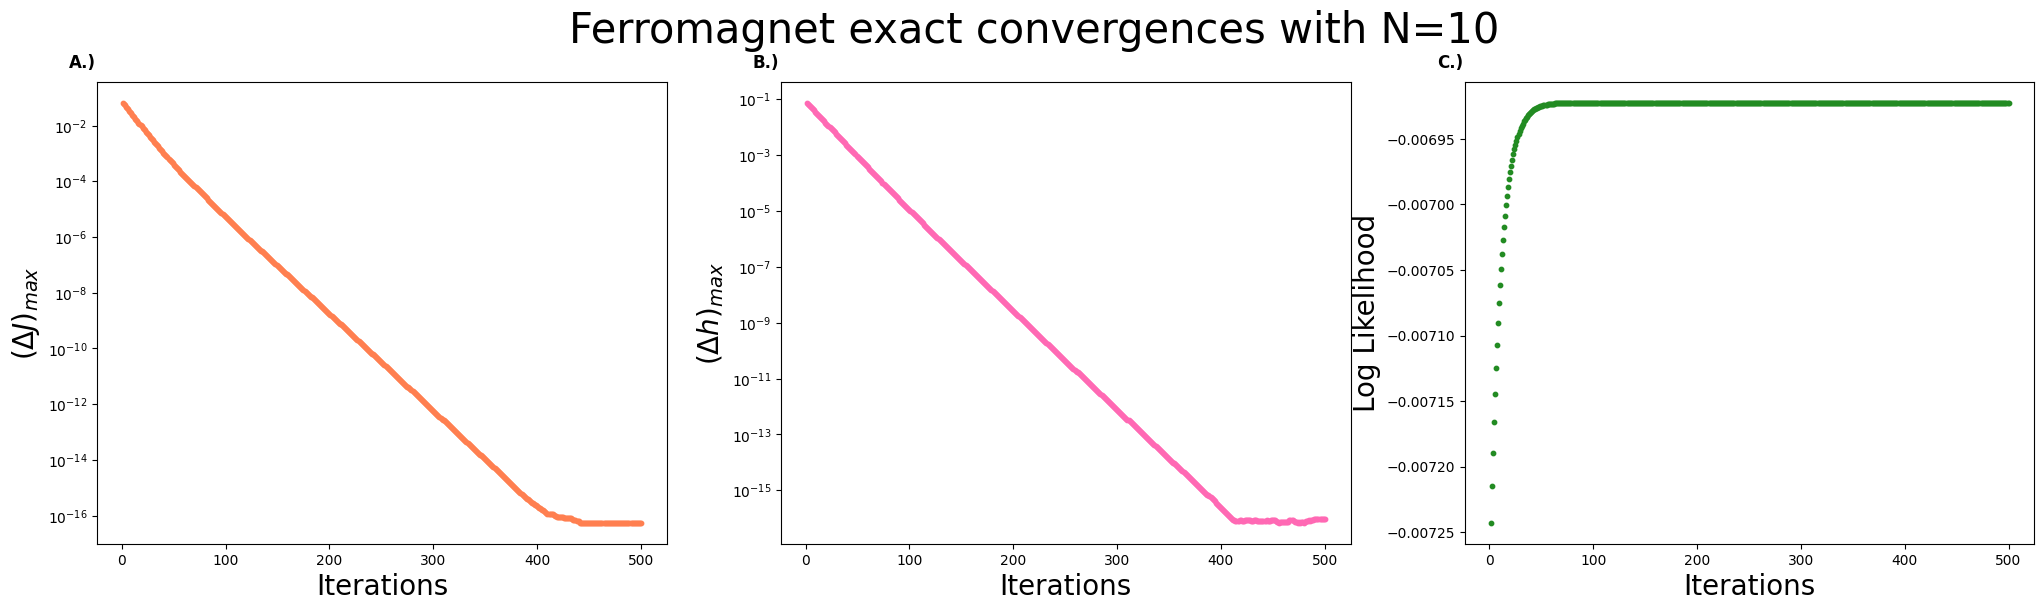

In [ ]:
eta         = 0.1     #  learning rate
Free_type   = 0       #  generate free statistics using exact computation

#initialize weights
J, H, W_clamp, H_clamp, configs = initialize(N,j,h,sigma,seed_clamp,seed_free)

#run the simulation
J, H, W_clamp, H_clamp, it, Hmax, Wmax, Li= boltzmann_machine(N, T, eqSteps, mcSteps, J, H, W_clamp, H_clamp, configs, Free_type, threshold, maxiter, maxiter_MF, eta)

plot(it, Hmax, Wmax, Li, title = ('Ferromagnet exact convergences with N=%.f'% N), size = 10)

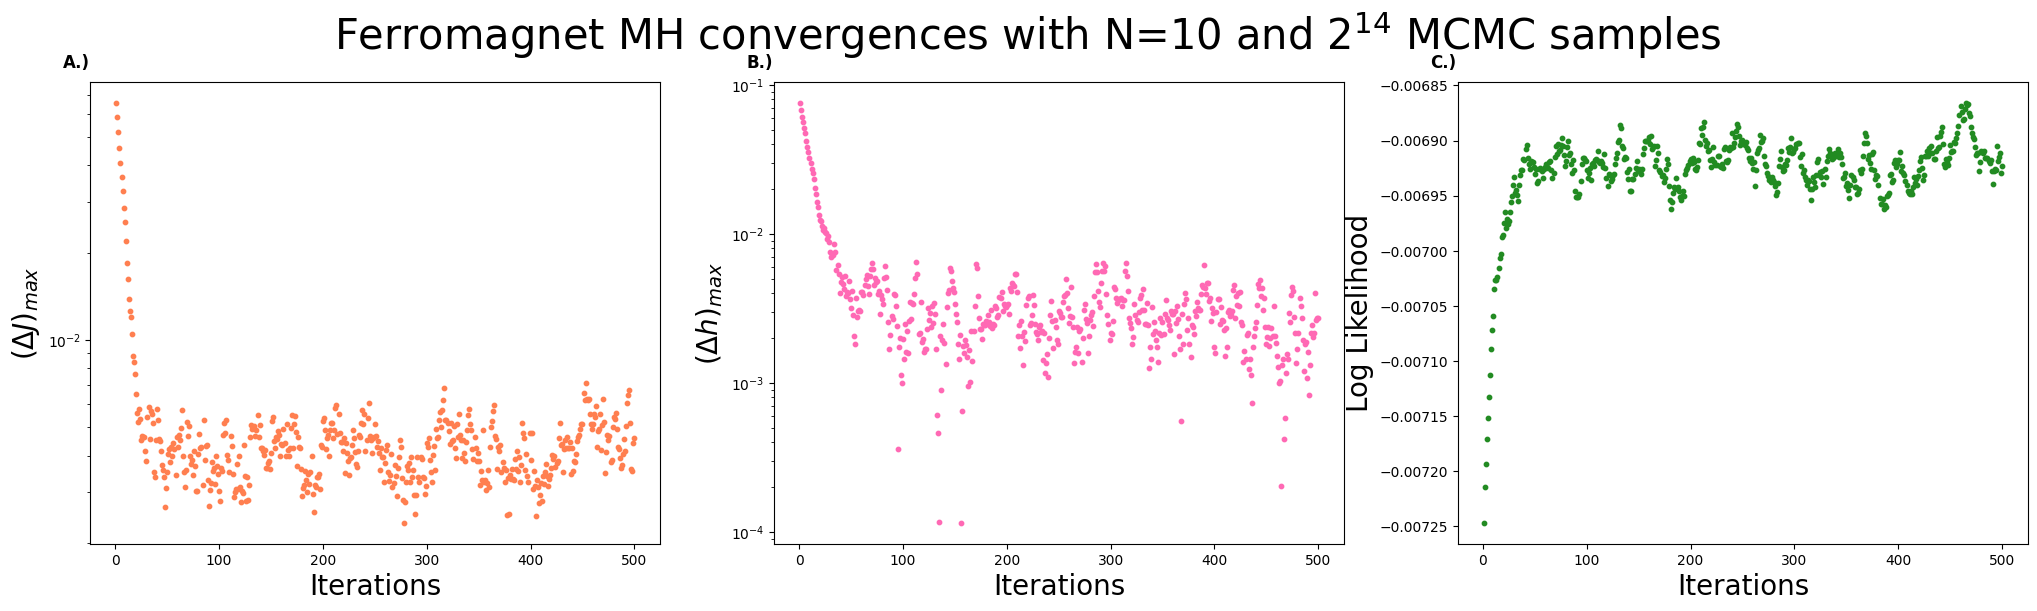

In [ ]:
Free_type = 1       #  generate free statistics using MCMC
eta       = 0.1     #  learning rate
eqSteps   = 2       # ignore this
mcSteps   = 2**14   #  number of MC sweeps for calculation

J, H, W_clamp, H_clamp, configs = initialize(N,j,h,sigma,seed_clamp,seed_free)
J, H, W_clamp, H_clamp, it, Hmax, Wmax, Li= boltzmann_machine(N, T, eqSteps, mcSteps, J, H, W_clamp, H_clamp, configs, Free_type, threshold, maxiter, maxiter_MF, eta)

plot(it, Hmax, Wmax, Li, title = ('Ferromagnet MH convergences with N=%.f and $2^{14}$ MCMC samples'%(N)), size = 10)

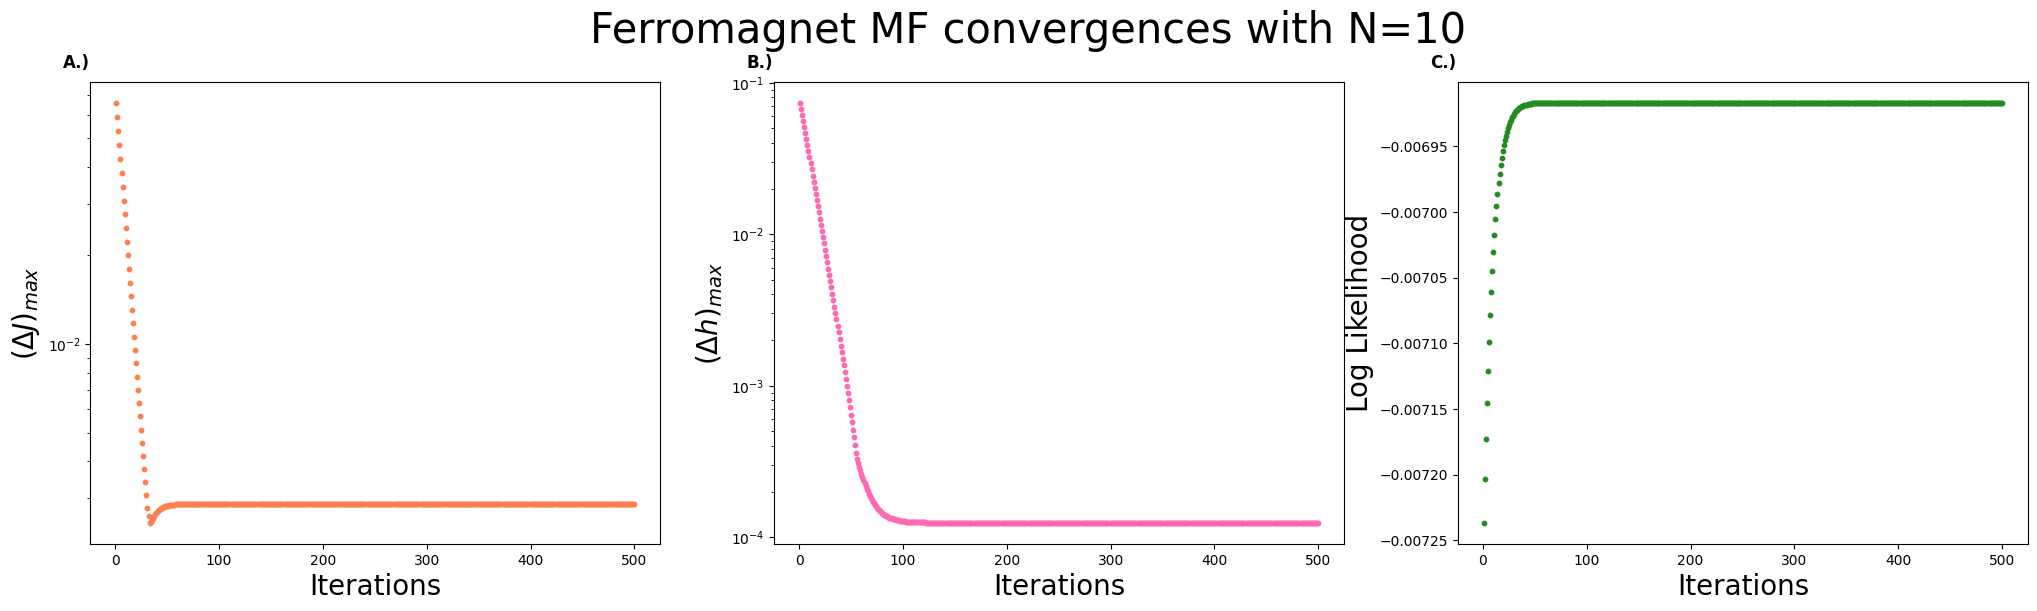

In [ ]:
Free_type   = 2       #  generate free statistics using MH approximation
eta         = 0.1     #  learning rate
maxiter_MF  = 100     #  number of iterations for MF convergence


J, H, W_clamp, H_clamp, configs = initialize(N,j,h,sigma,seed_clamp,seed_free)
J, H, W_clamp, H_clamp, it, Hmax, Wmax, Li= boltzmann_machine(N, T, eqSteps, mcSteps, J, H, W_clamp, H_clamp, configs,   Free_type, threshold, maxiter, maxiter_MF, eta)

plot(it, Hmax, Wmax, Li, title = ('Ferromagnet MF convergences with N=%.f'% N), size = 10)

In [ ]:
#TODO: Produce a plot that compares the accuracy of your sampled gradient with the exact evaluation of the gradient for small systems.

N = 10
T = 5
J, H = generate_weights_random(N, j = 0.1, h = 0.05, sigma = 0.2, seed = 444)
config = initial_config(N)

Ci_exact, CiCj_exact = ising_solve_exact(N, J, H, T, configs)
Ci_MH, CiCj_MH, config = ising_solve_MH(N, J, H, T, config, mcSteps)
Ci_MF, CiCj_MF = ising_solve_MF(N, J, H, T, maxiter_MF)

Avg_error_MH_Ci = np.mean(np.abs(Ci_exact - Ci_MH))
Avg_error_MH_CiCj = np.mean(np.abs(CiCj_exact - CiCj_MH))

Avg_error_MF_Ci = np.mean(np.abs(Ci_exact - Ci_MF))
Avg_error_MF_CiCj = np.mean(np.abs(CiCj_exact - CiCj_MF))

print(Avg_error_MH_Ci)
print(Avg_error_MH_CiCj)

print(Avg_error_MF_Ci)
print(Avg_error_MF_CiCj)

0.008433203230309097
0.006711344850294879
4.216668017893027e-06
0.02120163832303219


# Salamander Data

## 10 neurons

Apply the exact algorithm to 10 randomly selected neurons from the 160 neurons
of the salamaner retina, as discussed in [Schneidman et al., 2006]. The original
data file has dimension 160 x 283041, which are 297 repeated experiments,
each of which has 953 time points. Use only one of these repeats for training
the BM, ie. your data file for training has dimension 10 x 953. Reproduce
[Schneidman et al., 2006] fig 2a.

In [ ]:
!pip install gdown -q
!gdown https://drive.google.com/uc?id=1RGgcygKb49S1ZOilWNwnyZ9o1wU5qzN8

Downloading...
From: https://drive.google.com/uc?id=1RGgcygKb49S1ZOilWNwnyZ9o1wU5qzN8
To: /content/bint.txt
100% 90.6M/90.6M [00:00<00:00, 163MB/s]


We load the data such that each row corresponds to a neuron and each collumn to a timestep

In [ ]:
# load the first experiment for 160 neurons
columns_to_load = list(range(957))
data_full = pd.read_csv('bint.txt', delim_whitespace=True, header=None, usecols=columns_to_load)


# filter to keep only the selected 10 rows
np.random.seed(42)
rows_to_load = np.random.choice(160, 10, replace=False)
data = data_full.iloc[rows_to_load]
data = data.replace(0,-1).to_numpy() #replace 0 with -1 and add a small constant
data.shape

(10, 957)

We can now infer the data statistics from this. CiCj_clamp is the correlation matrix, so <s_i s_j> over all the 957 samples. Ci is the vector with all the means <s_i> for each neuron over all 957 time steps.
Also, our metric for convergence is different now since there is no oracle parameter matrix. Instead we output a matrix with the change of the parameters at each iteration compared to the previous time step.

We update the bolzmann machine to use these clamped statistics:

In [ ]:
def boltzmann_machine_salamander(N, T, eqSteps, mcSteps, J, H, data, Free_type, threshold, maxiter, eta, Z_exact = True):
    '''Solves the inverse Ising problem. Returns weight matrices that generated the clamped statistics
       and the inferred weight matrix along with the change of parameters at each iteration.'''
    beta = 1.0 / T

    # Initialize clamped statistics from data
    Ci_clamp = np.mean(data, axis=1)
    CiCj_clamp = np.einsum('ik,jk->ij', data, data) / (data.shape[1])


    # Data Checks
    if np.all(~np.isnan(CiCj_clamp)) and np.all(CiCj_clamp >= -1) and np.all(CiCj_clamp <= 1) and np.issubdtype(CiCj_clamp.dtype, np.float64):
        if np.all(~np.isnan(Ci_clamp)) and np.all(Ci_clamp >= -1) and np.all(Ci_clamp <= 1) and np.issubdtype(Ci_clamp.dtype, np.float64):
            print("Data is valid. It contains no NaN values, is bounded between -1 and 1 and is np.float64")
        else:
            print("Data is not valid. It may contain NaN values, not bounded between -1 and 1 or not of type np.float64")
    else:
        print("Data is not valid. It may contain NaN values, not bounded between -1 and 1 or not of type np.float64")


    config = initial_config(N)  # Initialize new state for free statistics

    # Initialize gradient ascent values
    it = 0
    H_max = W_max = 1
    Hmax_changes, Wmax_changes, Li_values = [], [], []  # Store values to plot
    H_previous, J_previous = H.copy(), J.copy()         # Keep track of previous values

    while it < maxiter and (H_max > threshold or W_max > threshold):  # Start gradient ascent
        it += 1

        # Generate free statistics based on type of solver
        if Free_type == 0:
            Ci_free, CiCj_free = ising_solve_exact(N, J, H, T, configs)
        elif Free_type == 1:
            Ci_free, CiCj_free, config = ising_solve_MH(N, J, H, T, config, mcSteps)
        elif Free_type == 2:
            Ci_free, CiCj_free = ising_solve_MF(N, J, H, T, maxiter_MF)

        # Update weight matrix based on statistics
        H = H + eta * (Ci_clamp - Ci_free)
        J = J + eta * (CiCj_clamp - CiCj_free)

        # Calculate maximum change compared to previous iteration
        H_change = np.abs(H - H_previous)
        J_change = np.abs(J - J_previous)

        # Update maximum changes
        H_max = np.max(H_change)
        W_max = np.max(J_change)

        Li = log_likelihood(beta, J, H, Ci_free, CiCj_free, Z_exact)

        # Store changes
        Hmax_changes.append(H_max)
        Wmax_changes.append(W_max)
        Li_values.append(Li)

        # Update previous values
        H_previous, J_previous = H.copy(), J.copy()

    return J, H, it, np.array(Hmax_changes), np.array(Wmax_changes), Li_values

In [ ]:
##  PARAMETERS
#----------------------------------------------------------------------
# model parameters
N           = 10       #  spin chain length
T           = 1        #  temperature scalar

# gradient ascent parameters
eta         = 1/10     #  learning rate
threshold   = 1e-17    #  threshold for stopping the gradient ascent loop
maxiter     = 10000    #  maximum number of gradient ascent iterations

#intial weights parameters
seed_clamp  = 234
seed_free   = 222       #  SCALE WEIGHTS BY FACTOR 1/N, CLOSE TO 0
j           = 0.00      #  initial guess of average interaction strength (average correlation over all neurons)
h           = 0.00     #  initial guess of average bias (mean value over all neurons)
sigma       = 0.04        #  standard deviation of the normal distribution

Data is valid. It contains no NaN values, is bounded between -1 and 1 and is np.float64


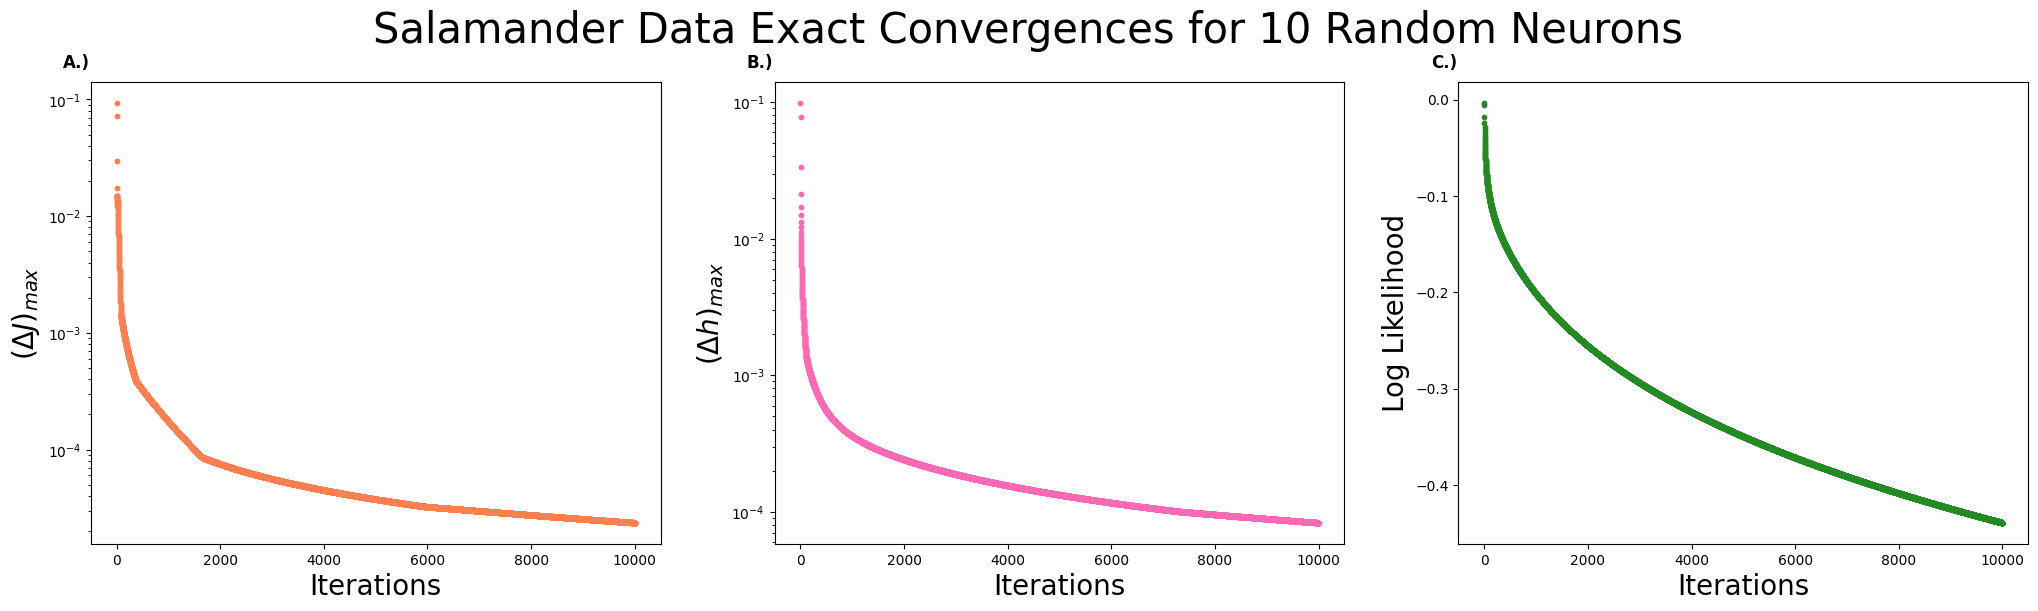

In [ ]:
Free_type = 0

#initialize weights
J, H, _, _, configs = initialize(N,j,h,sigma,seed_clamp,seed_free)

#run simulation
J, H, it, Hmax_changes, Wmax_changes, Li= boltzmann_machine_salamander(N, T, eqSteps, mcSteps, J, H, data, Free_type, threshold, maxiter, eta)

#plot
plot(it, Hmax_changes, Wmax_changes, Li, title = ('Salamander Data Exact Convergences for 10 Random Neurons'), size = 10)

## 160 Neurons

In [ ]:
# load the first experiment for 160 neurons
columns_to_load = list(range(957))
data_full = pd.read_csv('bint.txt', delim_whitespace=True, header=None, usecols=columns_to_load)

# filter to keep only the selected rows
np.random.seed(42)
rows_to_load = np.random.choice(160, 160, replace=False)
data = data_full.iloc[rows_to_load]
data = data.replace(1, 1 - 1e-15) #add small constant to 1
data = data.replace(0,-1 + 1e-15).to_numpy() #replace 0 with -1 and subtract small constant
data.shape

(160, 957)

In [ ]:
##  PARAMETERS
#----------------------------------------------------------------------
# model parameters
N           = 160      #  spin chain length
T           = 1        #  temperature scalar
threshold   = 1e-17    #  threshold for stopping the gradient ascent loop

#random weights parametera

seed_free   = 222
j           = 0.0        #  initial guess average strength of interactions
h           = 0.0        #  initial guess average bias
sigma       = 0.01          #  standard deviation of the normal distribution initial weights get drawn fro

Data is valid. It contains no NaN values, is bounded between -1 and 1 and is np.float64


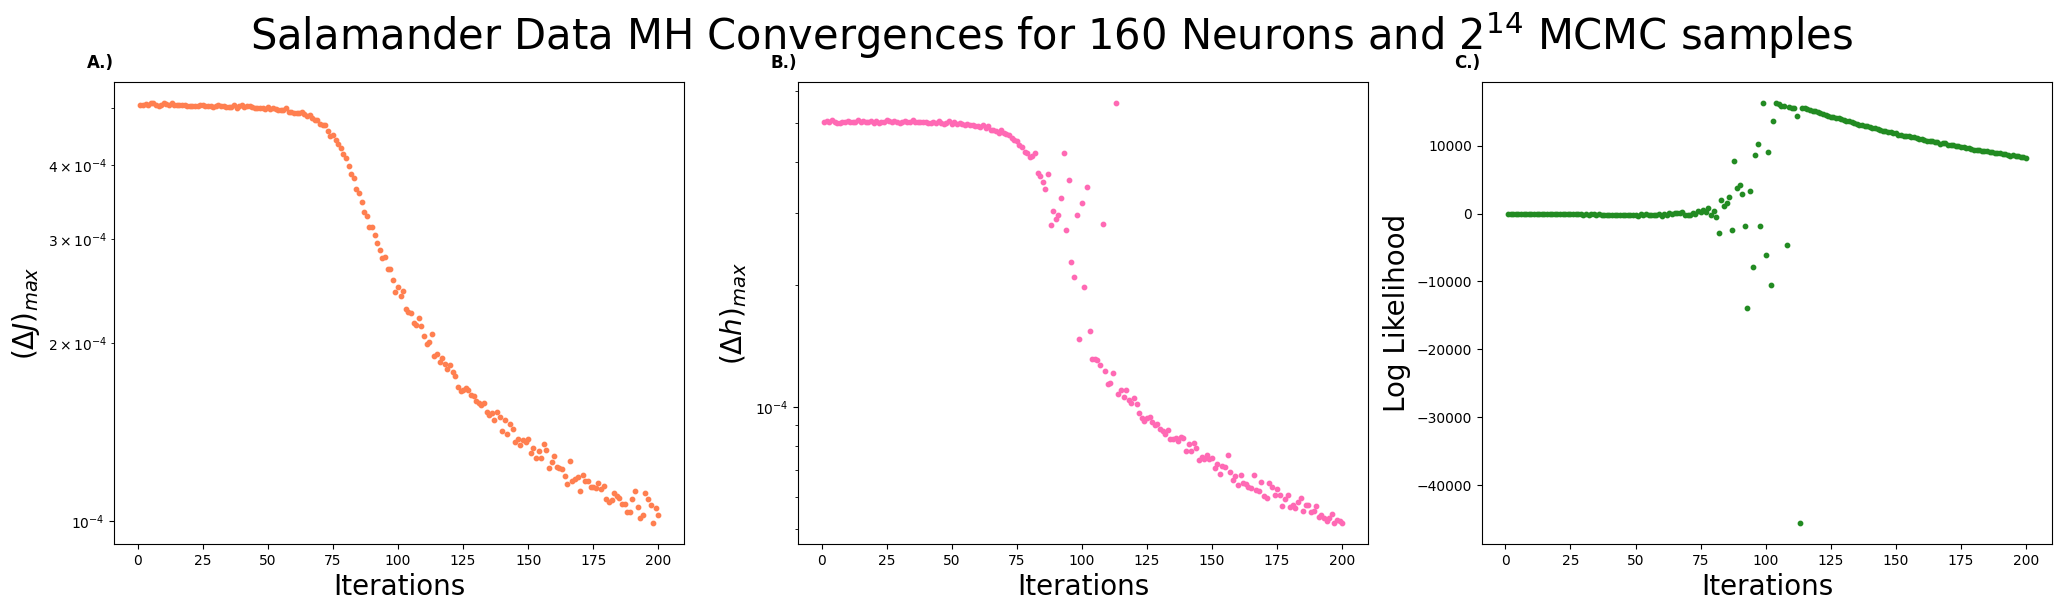

In [ ]:
Free_type   = 1         #  Infer free statistics using MH
mcSteps     = 2**14     #  number of MC sweeps for calculation


eta         = 1/10      #  learning rate
maxiter     = 200        #  maximum number of gradient ascent iterations

#initialize weights
J, H, _, _, configs = initialize(N,j,h,sigma,seed_clamp,seed_free, no_config=True)

#run simulation, Z_exact = False
J, H, it, Hmax_changes, Wmax_changes, Li= boltzmann_machine_salamander(N, T, eqSteps, mcSteps, J, H, data, Free_type, threshold, maxiter, eta, Z_exact = False)

#plot
plot(it, Hmax_changes, Wmax_changes, Li, title = ('Salamander Data MH Convergences for 160 Neurons and $2^{14}$ MCMC samples'), size = 10)

Data is valid. It contains no NaN values, is bounded between -1 and 1 and is np.float64


<ipython-input-61-10d02976d51e>:61: RuntimeWarning: divide by zero encountered in divide
  A = delta / (1-s_i**2) - J
<ipython-input-61-10d02976d51e>:61: RuntimeWarning: invalid value encountered in divide
  A = delta / (1-s_i**2) - J
<ipython-input-119-9c96525307be>:23: RuntimeWarning: divide by zero encountered in log
  S = 0.5 * np.sum((1 + mi) * np.log(1 + mi) + (1 - mi) * np.log(1 - mi))
<ipython-input-119-9c96525307be>:23: RuntimeWarning: invalid value encountered in multiply
  S = 0.5 * np.sum((1 + mi) * np.log(1 + mi) + (1 - mi) * np.log(1 - mi))


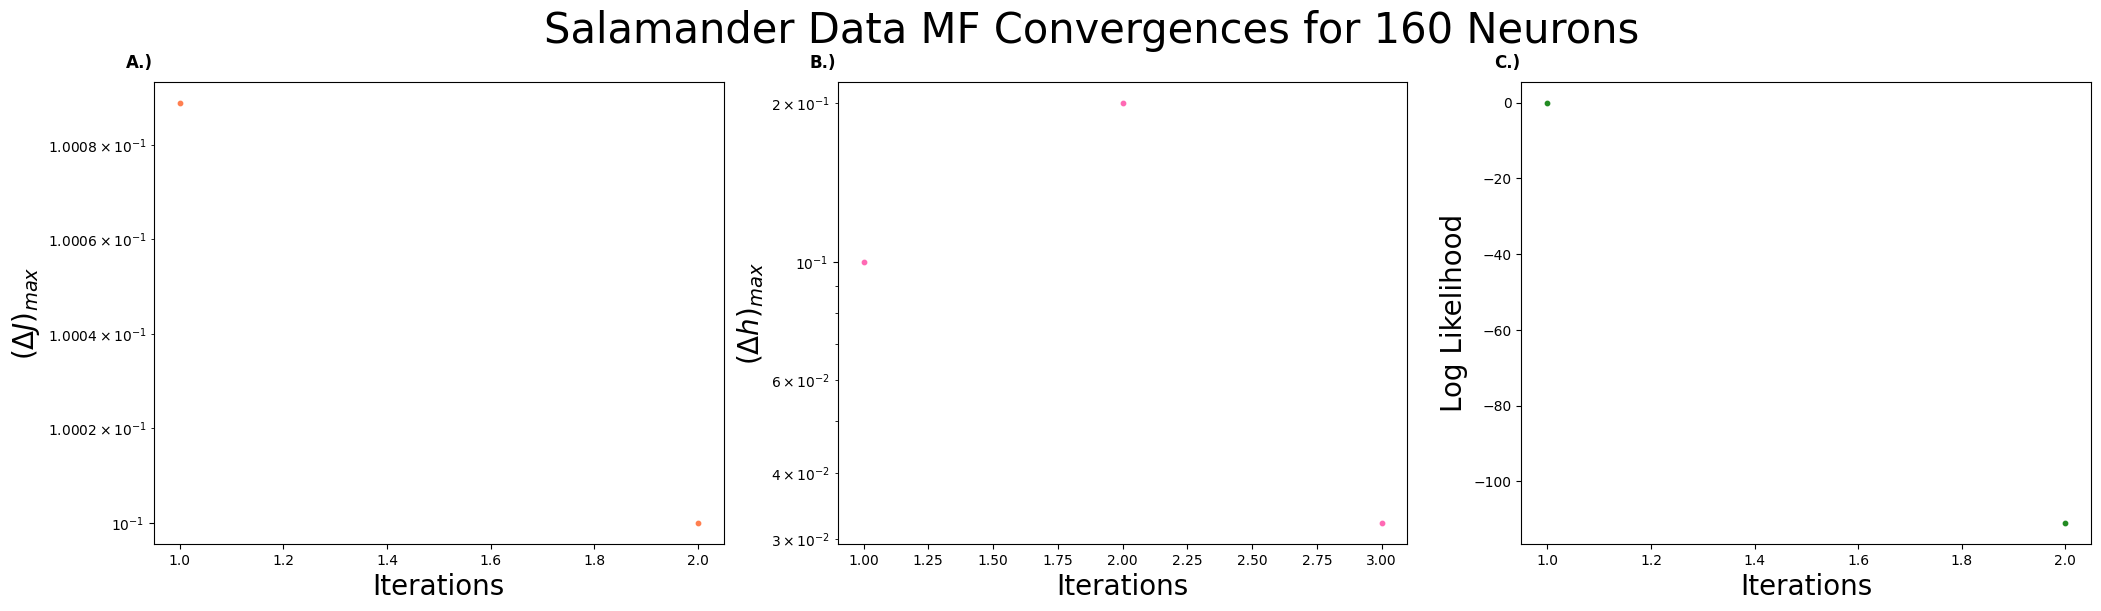

In [ ]:
Free_type   = 2        #  Infer free statistics using MH
maxiter_MF  = 500      #  number of iterations for MF convergence

T           = 1        #  temperature scalar
eta         = 1/10     #  learning rate
maxiter     = 200      #  maximum number of gradient ascent iterations

#initialize weights
J, H, _, _, configs = initialize(N,j,h,sigma,seed_clamp,seed_free, no_config=True)

#run simulation, Z_exact = False
J, H, it, Hmax_changes, Wmax_changes, Li= boltzmann_machine_salamander(N, T, eqSteps, mcSteps, J, H, data, Free_type, threshold, maxiter, eta, Z_exact = False)

#plot
plot(it, Hmax_changes, Wmax_changes, Li, title = ('Salamander Data MF Convergences for 160 Neurons'), size = 10)

## Last Point

In [ ]:
# Load the Salamander Retina Data
columns_to_load = list(range(957))
data_full = pd.read_csv('/content/bint.txt', delim_whitespace=True, header=None, usecols=columns_to_load)

# Filter to keep only the selected rows
np.random.seed(42)
rows_to_load = np.random.choice(160, 10, replace=False)
data = data_full.iloc[rows_to_load].to_numpy()


10


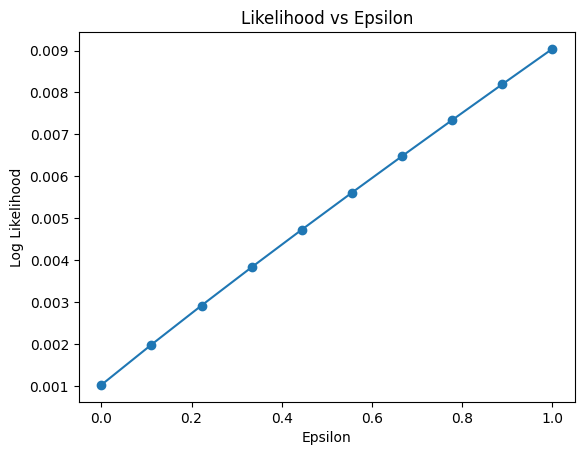

In [ ]:

print(data.shape[0])
# Compute clamped statistics from data
Ci_clamp = np.mean(data, axis=1)
CiCj_clamp = np.corrcoef(data)

# Implement Kronecker delta function
delta = np.eye(CiCj_clamp.shape[0])

# Loop over different values of epsilon
epsilon_values = np.linspace(0, 1, 10)  # Adjust the range and number of values as needed

likelihoods = []
beta = 1
for epsilon in epsilon_values:


    # Estimate free statistics with clamped ones using mean field equations with linear response correction

    # Compute J
    J = CiCj_clamp - np.outer(Ci_clamp, Ci_clamp) + epsilon * np.eye(CiCj_clamp.shape[0])

    # Compute m
    m = Ci_clamp


    # Compute w
    wi_j = (delta / (1 - m**2) )- np.linalg.inv(J)


    # Compute H

    H = np.arctanh(m) - wi_j @ m
    #print('H is', H)
    # Compute log likelihood
    log_likelihood_value = log_likelihood(beta, J, H, Ci_clamp, CiCj_clamp)

    likelihoods.append(log_likelihood_value)

# Plot the likelihood as a function of epsilon
plt.plot(epsilon_values, likelihoods, marker='o')
plt.xlabel('Epsilon')
plt.ylabel('Log Likelihood')
plt.title('Likelihood vs Epsilon')
plt.show()
